In [1]:
!pip install -q tensorflow matplotlib seaborn tqdm

In [2]:
%env TF_XLA_FLAGS=--tf_xla_auto_jit=0
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import random
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

env: TF_XLA_FLAGS=--tf_xla_auto_jit=0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
image_train_path = "/content/drive/MyDrive/Skripsi/Final/Split/Resized/Images/Train"
image_val_path   = "/content/drive/MyDrive/Skripsi/Final/Split/Resized/Images/Val"
image_test_path  = "/content/drive/MyDrive/Skripsi/Final/Split/Resized/Images/Test"

mask_train_path = "/content/drive/MyDrive/Skripsi/Final/Split/Resized/Labels/Train"
mask_val_path   = "/content/drive/MyDrive/Skripsi/Final/Split/Resized/Labels/Val"
mask_test_path  = "/content/drive/MyDrive/Skripsi/Final/Split/Resized/Labels/Test"

train_images = sorted([os.path.join(image_train_path, fname) for fname in os.listdir(image_train_path)])
train_masks  = sorted([os.path.join(mask_train_path, fname) for fname in os.listdir(mask_train_path)])

val_images = sorted([os.path.join(image_val_path, fname) for fname in os.listdir(image_val_path)])
val_masks  = sorted([os.path.join(mask_val_path, fname) for fname in os.listdir(mask_val_path)])

test_images = sorted([os.path.join(image_test_path, fname) for fname in os.listdir(image_test_path)])
test_masks  = sorted([os.path.join(mask_test_path, fname) for fname in os.listdir(mask_test_path)])


print("Jumlah data training:", len(train_images))
print("Jumlah data testing:", len(test_images))
print("JUmlah data validasi:", len(val_images))

Jumlah data training: 1183
Jumlah data testing: 338
JUmlah data validasi: 169


In [5]:
IMG_HEIGHT = 32
IMG_WIDTH = 32
NUM_CLASSES = 2  # background + tumor
BATCH_SIZE = 1
EPOCHS = 50
LEARNING_RATE = 1e-4
ANCHOR_SIZES = [32]

In [6]:
# Function untuk load image dan mask tanpa resize
def load_image_mask(image_path, mask_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (32, 32))  # Resize ke 32x32
    image = tf.image.convert_image_dtype(image, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_jpeg(mask, channels=1)
    mask = tf.image.resize(mask, (32, 32))  # Resize ke 32x32
    mask = tf.image.convert_image_dtype(mask, tf.float32)
    mask = tf.where(mask > 0.5, 1.0, 0.0)

    return image, mask

def get_dataset(image_paths, mask_paths, batch_size=BATCH_SIZE):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
    dataset = dataset.shuffle(buffer_size=len(image_paths))
    dataset = dataset.map(load_image_mask, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

def generate_dummy_outputs(image, mask):
    batch_size = tf.shape(image)[0]

    dummy_rpn_class_logits = tf.zeros((batch_size, IMG_HEIGHT // 8, IMG_WIDTH // 8, 9), dtype=tf.float32)
    dummy_rpn_probs = tf.zeros((batch_size, IMG_HEIGHT // 8, IMG_WIDTH // 8, 9), dtype=tf.float32)
    dummy_rpn_bbox = tf.zeros((batch_size, IMG_HEIGHT // 8, IMG_WIDTH // 8, 36), dtype=tf.float32)
    dummy_class_logits = tf.zeros((batch_size, 32, NUM_CLASSES), dtype=tf.float32)
    dummy_bbox_fc = tf.zeros((batch_size, 32, NUM_CLASSES * 4), dtype=tf.float32)

    # Mask tidak perlu resize lagi
    resized_mask = mask
    resized_mask = tf.expand_dims(resized_mask, axis=-1)
    resized_mask = tf.tile(resized_mask, [1, 1, 1, NUM_CLASSES])

    return image, (dummy_rpn_class_logits, dummy_rpn_probs, dummy_rpn_bbox, dummy_class_logits, dummy_bbox_fc, resized_mask)

In [7]:
# Datasets
train_dataset = get_dataset(train_images, train_masks)
val_dataset = get_dataset(val_images, val_masks)
test_dataset = get_dataset(test_images, test_masks)

In [8]:
def build_backbone_fpn():
    base_model = keras.applications.ResNet50(include_top=False, input_shape=[IMG_HEIGHT, IMG_WIDTH, 3])
    c3_output = base_model.get_layer("conv3_block4_out").output
    c4_output = base_model.get_layer("conv4_block6_out").output
    c5_output = base_model.get_layer("conv5_block3_out").output

    p5 = layers.Conv2D(256, 1)(c5_output)
    p4 = layers.Add()([
        layers.UpSampling2D()(p5),
        layers.Conv2D(256, 1)(c4_output)
    ])
    p3 = layers.Add()([
        layers.UpSampling2D()(p4),
        layers.Conv2D(256, 1)(c3_output)
    ])
    p3 = layers.Conv2D(256, 3, padding="same")(p3)
    p4 = layers.Conv2D(256, 3, padding="same")(p4)
    p5 = layers.Conv2D(256, 3, padding="same")(p5)

    return keras.Model(inputs=base_model.input, outputs=[p3, p4, p5])

In [9]:
def build_rpn():
    input_feature = layers.Input(shape=[None, None, 256])
    shared = layers.Conv2D(256, 3, padding="same", activation="relu")(input_feature)
    rpn_class_logits = layers.Conv2D(9, 1)(shared)
    rpn_probs = layers.Activation("sigmoid")(rpn_class_logits)
    rpn_bbox = layers.Conv2D(9 * 4, 1)(shared)
    return keras.Model(inputs=input_feature, outputs=[rpn_class_logits, rpn_probs, rpn_bbox])

In [10]:
class ROIAlign(layers.Layer):
    def __init__(self, pool_size):
        super(ROIAlign, self).__init__()
        self.pool_size = pool_size

    def call(self, inputs):
        feature_maps, proposals = inputs  # feature_maps: [batch, H, W, C], proposals: [batch, num_proposals, 4]

        batch_size = tf.shape(feature_maps)[0]
        num_proposals = tf.shape(proposals)[1]

        # Reshape proposals to [batch_size * num_proposals, 4]
        proposals = tf.reshape(proposals, [batch_size * num_proposals, 4])

        # Ensure proposals are in [y1, x1, y2, x2] format and normalized
        y1 = proposals[:, 0]
        x1 = proposals[:, 1]
        y2 = proposals[:, 2]
        x2 = proposals[:, 3]

        # Ensure y1 < y2 and x1 < x2
        y1 = tf.minimum(y1, y2)
        y2 = tf.maximum(y1, y2)
        x1 = tf.minimum(x1, x2)
        x2 = tf.maximum(x1, x2)

        # Stack back into proposals
        proposals = tf.stack([y1, x1, y2, x2], axis=1)

        # Clip proposals to [0, 1]
        proposals = tf.clip_by_value(proposals, 0.0, 1.0)

        # Create box indices
        box_indices = tf.repeat(tf.range(batch_size), num_proposals)

        # Apply crop_and_resize
        rois = tf.image.crop_and_resize(
            feature_maps,
            boxes=proposals,
            box_indices=box_indices,
            crop_size=self.pool_size
        )

        # Reshape to [batch_size, num_proposals, pool_height, pool_width, channels]
        channels = tf.shape(feature_maps)[-1]
        rois = tf.reshape(rois, [batch_size, num_proposals, self.pool_size[0], self.pool_size[1], channels])

        return rois


In [25]:
# Detection Head
def build_detection_head(pool_size, num_classes):
    inputs = layers.Input(shape=(pool_size, pool_size, 256))
    x = layers.Conv2D(256, (3, 3), padding="same", activation="relu")(inputs)
    x = layers.Conv2D(256, (3, 3), padding="same", activation="relu")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(1024, activation="relu")(x)
    x = layers.Dense(1024, activation="relu")(x)
    class_logits = layers.Dense(num_classes)(x)
    bbox_fc = layers.Dense(num_classes * 4)(x)
    return keras.Model(inputs, outputs=[class_logits, bbox_fc])

# Mask Head
def build_mask_head(pool_size, num_classes):
    inputs = layers.Input(shape=(pool_size, pool_size, 256))
    x = layers.Conv2D(256, 3, padding="same", activation="relu")(inputs)
    x = layers.Conv2D(256, 3, padding="same", activation="relu")(x)

    x = layers.UpSampling2D(size=(2, 2))(x)  # up 2x
    x = layers.Conv2D(256, 3, padding="same", activation="relu")(x)

    x = layers.UpSampling2D(size=(2, 2))(x)  # up 2x
    x = layers.Conv2D(256, 3, padding="same", activation="relu")(x)

    mask = layers.Conv2D(num_classes, 1, activation="sigmoid")(x)

    # Resize FINAL output ke 32x32
    mask = layers.Resizing(32, 32, interpolation="bilinear")(mask)

    return keras.Model(inputs, mask)

In [12]:
# Main Model Setup
backbone = build_backbone_fpn()
rpn_model = build_rpn()
roi_align = ROIAlign(pool_size=(14, 14))
detection_head = build_detection_head(14, NUM_CLASSES)
mask_head = build_mask_head(pool_size=14, num_classes=1)

input_image = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
feature_maps = backbone(input_image)
rpn_class_logits, rpn_probs, rpn_bbox = rpn_model(feature_maps[0])

# Dummy Proposals (for testing, replace with actual RPN output)
proposals = layers.Lambda(lambda x: tf.random.uniform((tf.shape(x)[0], 16, 4), minval=0, maxval=1))(input_image)

# Disable XLA for the CropAndResize operation within ROIAlign
@tf.function(jit_compile=False)
def roi_align_fn(inputs):
    return roi_align(inputs)

# Now call roi_align_fn instead of directly calling roi_align
rois = roi_align([feature_maps[0], proposals])
rois = layers.Lambda(lambda x: tf.reshape(x, (-1, x.shape[2], x.shape[3], x.shape[4])))(rois)

class_logits, bbox_fc = detection_head(rois)
mask = mask_head(rois)  # Mask head generates upsampled mask

# Build final model
# Change here: Only output the mask
model = models.Model(inputs=input_image, outputs=[mask])

# Compile model
# Change here: Remove extra losses and use custom_loss or binary_crossentropy
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    jit_compile=False  # Disable XLA for the entire model
)

model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ [(None, 4, 4,     │ 26,276,224 │ input_layer_4[0]… │
│ (Functional)        │ 256), (None, 2,   │            │                   │
│                     │ 2, 256), (None,   │            │                   │
│                     │ 1, 1, 256)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 16, 4)     │          0 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ roi_align           │ (None, 16, 14,    │          0 │ functional[0][0], │
│ (ROIAlign)          │ 14, 256)          │            │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 14, 14,    │          0 │ roi_align[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_3        │ (None, 32, 32, 1) │  3,082,497 │ lambda_1[0][0]    │
│ (Functional)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 29,358,721 (111.99 MB)

 Trainable params: 29,305,601 (111.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [13]:
history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=EPOCHS)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['conv2d_4/kernel', 'conv2d_4/bias', 'conv2d_5/kernel', 'conv2d_5/bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


1183/1183 ━━━━━━━━━━━━━━━━━━━━ 421s 295ms/step - loss: 0.2035 - val_loss: 0.9345
Epoch 2/50
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 341s 288ms/step - loss: 0.1371 - val_loss: 0.9345
Epoch 3/50
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 342s 289ms/step - loss: 0.1228 - val_loss: 0.9345
Epoch 4/50
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 341s 289ms/step - loss: 0.1139 - val_loss: 0.9127
Epoch 5/50
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 341s 288ms/step - loss: 0.1118 - val_loss: 0.8537
Epoch 6/50
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 341s 288ms/step - loss: 0.1077 - val_loss: 0.7972
Epoch 7/50
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 341s 288ms/step - loss: 0.1008 - val_loss: 0.8636
Epoch 8/50
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 340s 287ms/step - loss: 0.0971 - val_loss: 0.9517
Epoch 9/50
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 341s 289ms/step - loss: 0.0909 - val_loss: 0.8873
Epoch 10/50
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 341s 288ms/step - loss: 0.0848 - val_loss: 0.9348
Epoch 11/50
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 340s 287ms/step - loss: 0.0819 - val_loss: 0.94

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

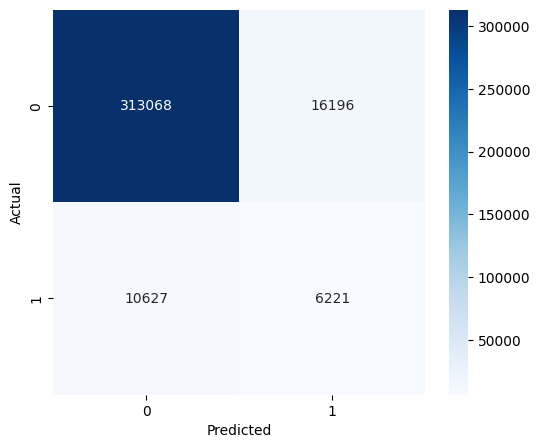

In [33]:
# Membaca dan memproses ground truth mask (y_true)
y_true = []
for mask_path in test_masks:
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (32, 32))  # Resize sesuai ukuran input model
    mask = (mask > 127).astype(int)  # Mask jadi binary (0 atau 1)
    y_true.append(mask)
y_true = np.array(y_true)
y_true = y_true.flatten()  # Flatten untuk evaluasi

# Prediksi hasil model (y_pred)
y_pred = []
for image_path in test_images:
    image = cv2.imread(image_path)
    image = cv2.resize(image, (32, 32))  # Resize sesuai ukuran input model
    image = np.expand_dims(image, axis=0)  # Tambahkan batch dimension

    pred_mask = model.predict(image)[0]  # Ambil prediksi untuk satu gambar
    pred_mask = (pred_mask > 0.5).astype(int)  # Thresholding untuk membuat prediksi binary (0 atau 1)

    y_pred.append(pred_mask.flatten())  # Flatten hasil prediksi untuk gambar ini

# Konversi y_pred menjadi array numpy untuk evaluasi
y_pred = np.array(y_pred)
y_pred = y_pred.flatten()  # Flatten untuk evaluasi

# Evaluasi model
print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred))
print("Recall:", recall_score(y_true, y_pred))
print("F1 Score:", f1_score(y_true, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


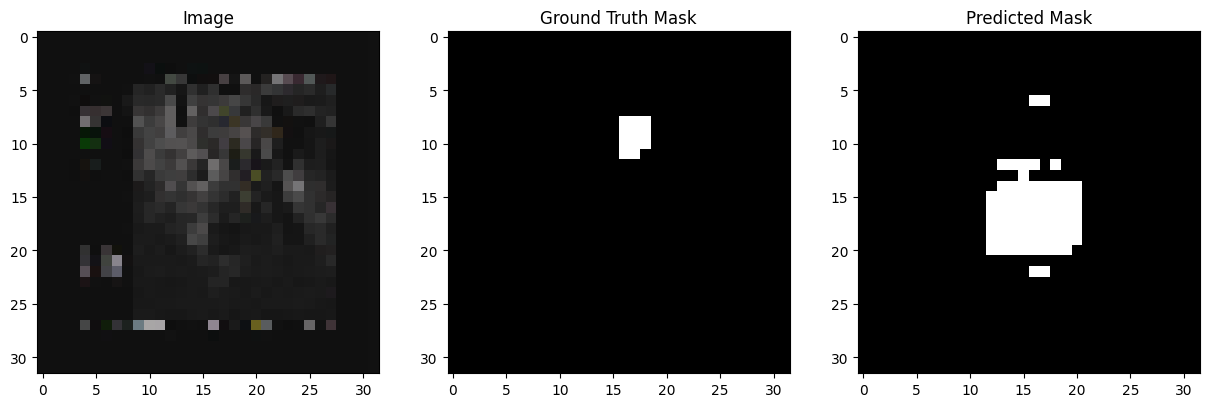

In [35]:
# Membaca gambar dan mask ground truth
sample_image = cv2.imread(test_images[0])  # Membaca gambar
sample_image = cv2.resize(sample_image, (32, 32))  # Resize ke 32x32 sesuai ukuran input model

true_mask = cv2.imread(test_masks[0], cv2.IMREAD_GRAYSCALE)  # Membaca mask ground truth
true_mask = cv2.resize(true_mask, (32, 32))  # Resize ke 32x32 sesuai ukuran input model
true_mask = (true_mask > 127).astype(int)  # Threshold untuk membuat mask biner (0 atau 1)

# Prediksi model
sample_image_input = np.expand_dims(sample_image, axis=0)  # Tambahkan batch dimension
pred_mask = model.predict(sample_image_input)[0]  # Ambil prediksi untuk satu gambar
pred_mask = (pred_mask > 0.5).astype(int)  # Thresholding untuk mendapatkan mask biner (0 atau 1)

# Visualisasi hasil
plt.figure(figsize=(15,5))

# Gambar asli
plt.subplot(1,3,1)
plt.imshow(sample_image)
plt.title("Image")

# Ground truth mask
plt.subplot(1,3,2)
plt.imshow(true_mask, cmap="gray")
plt.title("Ground Truth Mask")

# Predicted mask
plt.subplot(1,3,3)
plt.imshow(pred_mask.squeeze(), cmap="gray")  # Menghapus dimensi ekstra
plt.title("Predicted Mask")

plt.show()